# Imports

In [207]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.stattools as st

from rdrobust import rdplot
from rdrobust import rdrobust
from scipy.stats import norm

# Methods

Methods for Identification 

In [208]:
def sign(x):
    """
    This function computes the sign of the given observation.

    Parameters
    ----------
    x : int
        The observation to compute the sign.

    Returns
    -------
    sign: int 
        Returns -1 if x is negative and 1 if nonnegative.
    """
    if x<0:
        return -1
    else:
        return 1

def treatment(x):
    """
    This function computes if an observation has received treatment.

    Parameters
    ----------
    x : int
        The observation to compute the treatment variable.

    Returns
    -------
    treatment: int 
        Returns 0 if observation x does not receive treatment and 1 if it does receive treatment.
    """
    if x<0:
        return 0
    else:
        return 1

def indicator(x):
    """
    This indicator function computes if an observation is within a distance of the threshold.

    Parameters
    ----------
    x : int
        The observation to compute the indicator value.

    Returns
    -------
    treatment: int 
        Returns 1 if observation x is within the distance and 0 if it is not.
    """
    if np.abs(x)<0.1:
        return 1
    else:
        return 0


def genT(X):
    """
    This function creates an array of treatment variables for a sample of observations.

    Parameters
    ----------
    X : arrray[int]
        The sample of observation to compute the treatment values for.

    Returns
    -------
    T: array[int]
        Returns an array with 1's and 0's for each observation depending on wether that observation received treatment.
    """
    T = {}
    for i in range(len(X)):
        T = np.append(T,treatment(X[i]))
    T = np.delete(T,0)
    return T
            


Methods for Generation of Outcomes: $Y_{i} = \mu(X_{i}) + \varepsilon_i$

$Y_{i}$ from Noak and Rothe 2023 donut RDD paper: 
$\newline \mu_N(x)=sign(x)*x^2-L*sign(x)((x-\delta*sign(x))^2-\delta^2*sign(x))*\boldsymbol{1}\{|x|<\delta\}$

In [209]:
def mu_noak(L,x):
    """
    This function generates the non-random part of outcome function with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part of the outcome value for that observation.
    """
    return sign(x)*np.power(x,2) - L*sign(x)*(np.power(x-0.1*sign(x),2)-np.power(0.1,2)*sign(x))*indicator(x)

def genY_noak(L,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_noak(L,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

Basic linear outcomes ($Y_{i}$) plus simple treatment effect: $\quad \mu_{BL}(x)= \alpha + \beta x + \tau t$

In [210]:
def mu_basicLinear(tau,alpha,beta,x): 
    """
    This function generates the non-random part of the outcome function with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part the outcome value.
    """
    return alpha + beta*x + tau*treatment(x)

def genY_basicLinear(tau,alpha,beta,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_basicLinear(tau,alpha,beta,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

# Sample Generation 

Seed Set-up

In [211]:
sd = np.random.default_rng(seed=42)
print(sd)

Generator(PCG64)


Generation of the Outcomes ($Y_{i}$) given the different DGP's

In [212]:
def genY(name, X, tau=0, L=0, alpha=0, beta=0):
    """
    This function generates a sample of observations from the given DGP.

    Parameters
    ----------
    name: string
        The name of the DGP to use.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    tau : int, Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    epsilon = np.random.normal(0,0.5,len(X))
    if name == 'Noack':
        Y = genY_noak(L,X,epsilon)
    elif name == 'Basic Linear':
        Y = genY_basicLinear(tau,alpha,beta,X,epsilon)
    else:
        return NameError('Type of GDP is not recognised')
    return Y

In [259]:
def genOutlier(Y, X, name, nOutliers=1, delta=0.1):
    Outliers = np.zeros_like(Y)
    if name == 'Simple':
        i = 0
        for j in range(nOutliers):
            print(j)
            found=True
            while(found):
                if (X[i] >= -delta) & (X[i] < 0):
                    Y[i] = 2.5
                    Outliers[i] = 1
                    found = False
                    i=i+1
                else: 
                    i=i+1  

    if name == 'Simple Outside':
        i = 0
        for j in range(nOutliers):
            print(j)
            found=True
            while(found):
                if (X[i] >= -2*delta) & (X[i] < -delta):
                    Y[i] = 2.5
                    Outliers[i] = 1
                    print('found')
                    found = False
                    i=i+1
                else: 
                    i=i+1    
    return Y, Outliers

Generation os the Sample $X_i$'s and $Y_i$'s

In [248]:

def genSample(name, n, tau=0, L=0, alpha=0, beta=0, outlier=False, outlierMethod='',nOutliers=1, printPlot=True):
    """
    Generate a sample for RDD analysis: running variables (X), outcomes (Y), and treatments (T)

    Parameters
    ----------
    name: string, Options: 'Noak', 'Basic', 'Basic Linear'
        The name of the DGP to use to generate the sample.
    n: int
        The size of the sample.
    tau : int, Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.
    outlier: boolean
        True if sample should have an outlier(s)
    outlierMethod: string
        Name of the outlier generation method to use
    printPlot: boolean, Default value: False
        Defines if a plot is printed with the sample.

    Returns
    -------
    sample: DataFrame
        A dataframe object with the geneated Y (outcomes) and X (running variables) and given T (treatment variables)
    """
    X = np.random.uniform(-1,1,n)
    Y = genY(name, X, tau, L, alpha, beta)
    Outliers = np.zeros_like(Y)
    if outlier == True:
        Y, Outliers  = genOutlier(Y,X,outlierMethod,nOutliers)
    T = genT(X)

    # Create sample dataframe
    sample = pd.DataFrame({'Y': Y,'X': X,'T': T, 'Outlier': Outliers})
    sample.Y = sample.Y.astype(float)

    # Print plot
    if printPlot == True:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["grey","red"])
        plt.scatter(X,Y,s=6,c=sample.Outlier, cmap=cmap)
        plt.xlabel('$X_i$')
        plt.ylabel('$Y_i$')
        
    return sample

Test Generate Sample Command

0
found
1
found


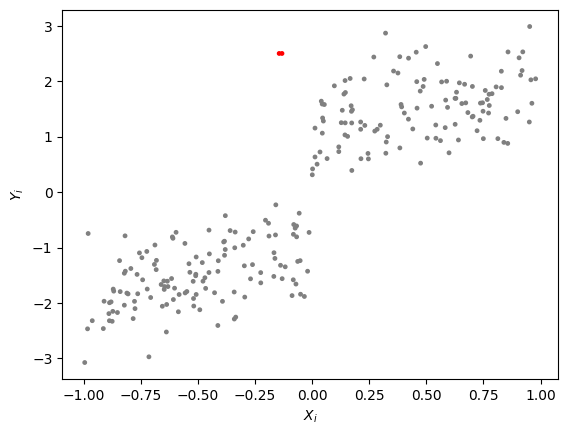

In [260]:
# Options are: 'Noak', 'Basic', 'Basic Linear'
sample = genSample('Basic Linear',250,tau=2,alpha=-1,beta=1,L=200,
                   outlier=True,outlierMethod='Simple Outside', nOutliers=2,printPlot=True)
#sample.to_csv('sample.csv')

In [235]:
def genExog(sample, intercept=False):
    exog = sample.copy() 
    exog = exog.drop('Y',axis='columns')
    exog = exog.drop('T',axis='columns')
    exog = exog.drop('Outlier',axis='columns')
    
    if (intercept == True):
        exog = sm.add_constant(exog)
    
    return exog

def fit(name, sample, intercept, cutoff=0):
    exog = genExog(sample,intercept)    

    if (name == 'Robust Huber'):
        res = sm.RLM(sample.Y,exog.to_numpy(),M=sm.robust.norms.HuberT())
    
    elif (name == 'Robust Tuckey'):
        res = sm.RLM(sample.Y,exog.to_numpy(),M=sm.robust.norms.TukeyBiweight())

    elif (name == 'OLS'):
        res = sm.OLS(sample.Y,exog.to_numpy())

    elif (name == 'Donut'):
        sample = sample.loc[np.abs(sample.X-cutoff)>=0.1]
        exog = genExog(sample,intercept)
        res = sm.OLS(sample.Y,exog.to_numpy())
        
    else:
        return NameError('Type of Estimation method is not recognised')
    
    res = res.fit()
    return res.params

def splitFit (name,sample,cutoff,intercept):
    # Split sample at cutoff
    sample_below = sample.loc[sample.X<=cutoff]
    sample_above = sample.loc[sample.X>cutoff]
    params_below = fit(name, sample_below,intercept=intercept)
    params_above = fit(name, sample_above,intercept=intercept)
    #print(params_below, params_above)
    return params_below, params_above

def fitRD(name,sample,cutoff):
    params_below, params_above  = splitFit(name,sample, cutoff, True)
    tau =  params_above.iloc[0] - params_below.iloc[0]
    return tau

def plotSplitFitComparison(sample, cutoff, name1, name2="", name3=""):
    # Fit regressions
    params1_below, params1_above  = splitFit(name1,sample, cutoff, True)
    tau1 =  params1_above.iloc[0] - params1_below.iloc[0]
    if name2 != "":
        params2_below, params2_above = splitFit(name2,sample, cutoff, True)
        tau2 =  params2_above.iloc[0] - params2_below.iloc[0]

    if name3 != "":
        params3_below, params3_above = splitFit(name3,sample, cutoff, True)
        tau3 =  params3_above.iloc[0] - params3_below.iloc[0]

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["grey","red"])
    # Plot scatter observations
    plt.figure(figsize=[17,9])
    plt.scatter(sample.X,sample.Y,s=6,c=sample.Outlier,cmap=cmap)
    plt.xlabel('$X_i$')
    plt.ylabel('$Y_i$')

    # Plot regresion lines
    x_below = np.linspace(min(sample.X),cutoff,100)
    x_above = np.linspace(cutoff,max(sample.X),100)
    plt.plot(x_below,params1_below.iloc[0]+params1_below.iloc[1]*x_below, color ='b', linewidth=0.7)
    plt.plot(x_above,params1_above.iloc[0]+params1_above.iloc[1]*x_above, color ='b', linewidth=0.7, label=name1+' (ate: '+str(round(tau1,2))+')')

    if name2 != "":
        plt.plot(x_below,params2_below.iloc[0]+params2_below.iloc[1]*x_below, color ='g', linewidth=0.7)
        plt.plot(x_above,params2_above.iloc[0]+params2_above.iloc[1]*x_above, color ='g', linewidth=0.7, label=name2+' (ate: '+str(round(tau2,2))+')')
    if name3 != "":
        plt.plot(x_below,params3_below.iloc[0]+params3_below.iloc[1]*x_below, color ='purple', linewidth=0.7)
        plt.plot(x_above,params3_above.iloc[0]+params3_above.iloc[1]*x_above, color ='purple', linewidth=0.7, label=name3+' (ate: ' +str(round(tau3,2))+')')

    plt.legend()

In [236]:
param = fit('Robust Huber',sample,True)
print(param)

const   -0.020257
x1       2.497592
dtype: float64


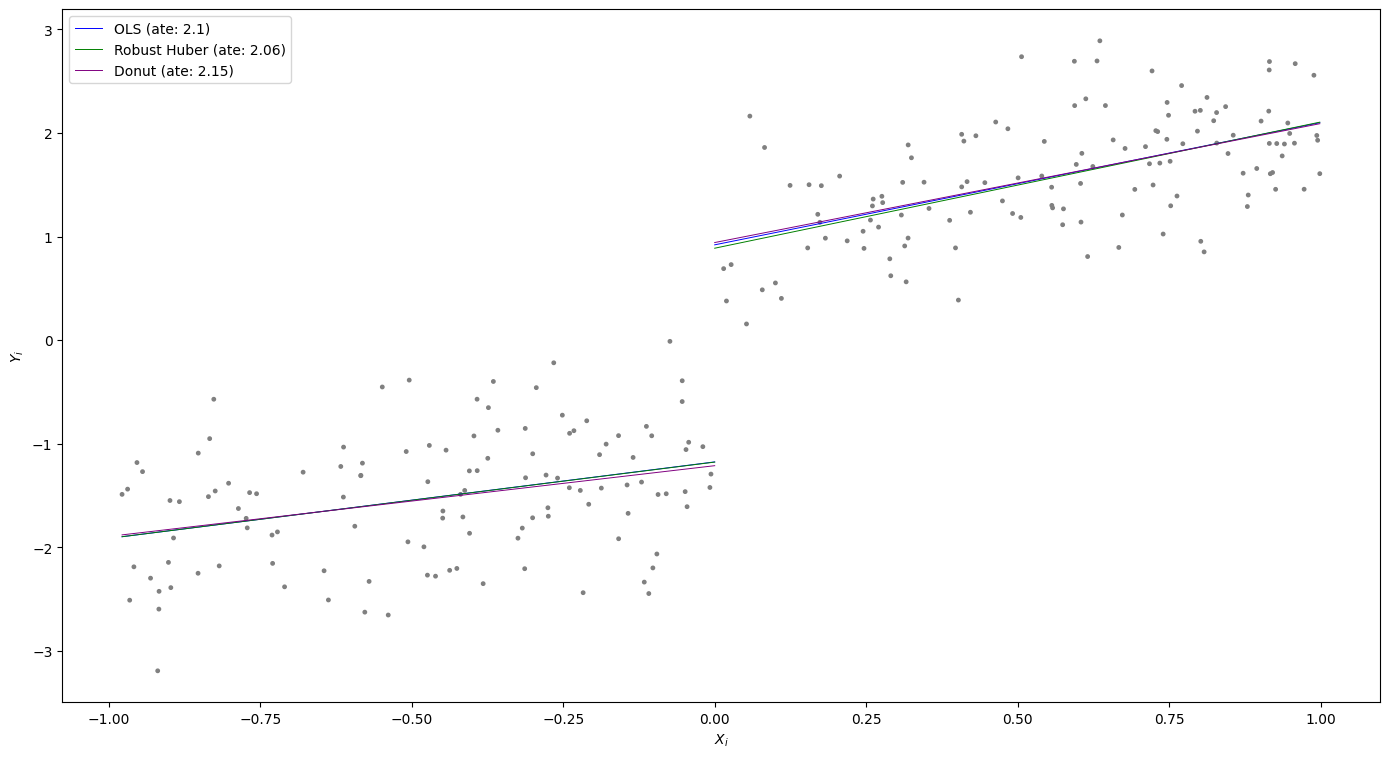

In [264]:
sample = genSample('Basic Linear',250,tau=2,alpha=-1,beta=1,L=200,
                   outlier=False,outlierMethod='Simple Outside', nOutliers=2,printPlot=False)
#sample['Xsq'] = sample.X**2
plotSplitFitComparison(sample,0,'OLS','Robust Huber','Donut')

In [ ]:
#rdrobust(sample.Y,sample.X,p=1)
#rdplot(sample.Y,sample.X,p=1)

# Simulation of Treatment Effects Estimation

In [ ]:
n = 1000
L = np.array([0,10,20,30,40])
tau = 2
a = -1
b = 1

In [240]:
def simulation(nameSample,n,r,tau=0, L=0, alpha=0, beta=0):
    """
    Run simulation analysis for RDD: Generates a sample r times and returns the results of each sample
    Parameters
    ----------
    nameSample: string, Options: 'Noak', 'Basic Linear'
        The name of the DGP to use to generate the sample.
    nameEstimation: string
        The name of the estimation method used to estimate ATE with RDD
    n: int
        The size of the sample.
    r: int 
        The number of replications.
    tau : int , Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.
   
    
    Returns
    -------
    sample: DataFrame
        A dataframe object with the results from the simulation. 
        For each smaple it returns the estimated Treatment Effects (TE), bandwidth (H).
    """ 
    t_OLS = {}
    t_RH = {}
    t_RT = {}
    t_D = {}

    for i in range(r):
        sample = genSample(nameSample,n,tau, L, alpha, beta, printPlot=False)
        t_OLS = np.append(t_OLS, fitRD('OLS',sample,0))
        t_RH = np.append(t_RH, fitRD('Robust Huber',sample,0))
        t_RT = np.append(t_RT, fitRD('Robust Tuckey',sample,0))
        t_D = np.append(t_D, fitRD('Donut',sample,0))
        #H_left = np.append(H_left,res.bws.left.iloc[0])
        #H_right = np.append(H_right,res.bws.right.iloc[0]) ,,,'H_left':H_left,'H_right':H_right
    
    t_OLS = np.delete(t_OLS,0)
    t_RH = np.delete(t_RH,0)
    t_RT = np.delete(t_RT,0)
    t_D = np.delete(t_D,0)

    #H_left = np.delete(H_left,0)
    #H_right = np.delete(H_right,0)
    simulationResults = pd.DataFrame({'t_OLS':t_OLS, 't_Huber':t_RH, 't_Tuckey':t_RT, 't_Donut':t_D})
    return simulationResults

In [ ]:
simulationResults = simulation('Basic Linear',1000,1000,2)

In [ ]:
np.mean(simulationResults.TE)

1.9983252252837675

In [ ]:
np.std(simulationResults.TE)

0.13313431588997607

(3.542470463589208,
 0.1701227179952857,
 -0.04971117005968051,
 3.274106711722517)

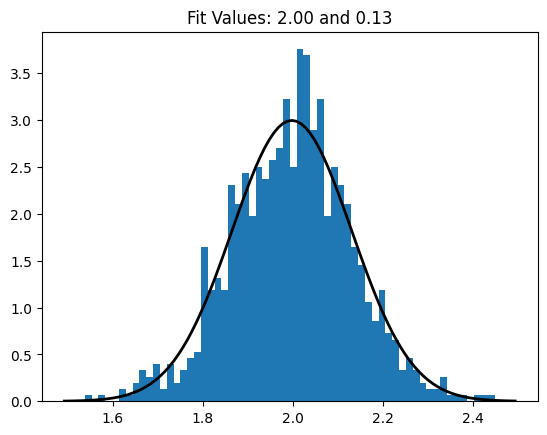

In [ ]:
hist = plt.hist(simulationResults.TE, bins=60, density=True)
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, np.mean(simulationResults.TE), np.std(simulationResults.TE))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(np.mean(simulationResults.TE), np.std(simulationResults.TE))
plt.title(title)

st.jarque_bera(simulationResults.TE)